<a href="https://colab.research.google.com/github/yohanesnuwara/machine-learning/blob/master/datacamp_notebooks/DataCamp_04_TreeModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Tree-based Machine Learning

## Set up.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, \
r2_score

from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestRegressor, \
AdaBoostClassifier, GradientBoostingRegressor, RandomForestClassifier

In [ ]:
!git clone https://github.com/yohanesnuwara/datasets

Cloning into 'datasets'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 437 (delta 4), reused 0 (delta 0), pack-reused 422
Receiving objects: 100% (437/437), 39.60 MiB | 20.48 MiB/s, done.
Resolving deltas: 100% (141/141), done.


In [ ]:
# Preprocessed datasets
def get_breast_cancer_data():
  df = pd.read_csv("/content/datasets/Wisconsin Breast Cancer.csv")

  # Encode diagnosis
  df.loc[df.diagnosis=="M", "diagnosis"] = 1
  df.loc[df.diagnosis=="B", "diagnosis"] = 0
  return df

def get_auto_data():
  df = pd.read_csv("/content/datasets/Automobile miles per gallon.csv") 
  df = pd.get_dummies(df)
  return df 

## Chapter 1.

* Decision tree for classification and regression (with "gini" and "entropy" criteria)

Decision tree for classification.

In [ ]:
df = get_breast_cancer_data()

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

(a) With "gini" criterion.

In [ ]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(criterion='gini', max_depth=6, random_state=1)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

[0 1 1 0 0]
Test set accuracy: 0.92


(b) With "entropy" criterion.

In [ ]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a DecisionTreeClassifier 'dt' with a maximum depth of 6
dt = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=1)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred = dt.predict(X_test)
print(y_pred[0:5])

# Compute test set accuracy  
acc = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(acc))

[0 1 1 0 0]
Test set accuracy: 0.91


Decision tree for regression.

In [ ]:
df = get_auto_data()

df.head()

,mpg,displ,hp,weight,accel,size,origin_Asia,origin_Europe,origin_US
0,18.0,250.0,88,3139,14.5,15.0,0,0,1
1,9.0,304.0,193,4732,18.5,20.0,0,0,1
2,36.1,91.0,60,1800,16.4,10.0,1,0,0
3,18.5,250.0,98,3525,19.0,15.0,0,0,1
4,34.3,97.0,78,2188,15.8,10.0,0,1,0


In [ ]:
# Define feature and target
X = df.iloc[:,1:].values
y = df.mpg.values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=8, min_samples_leaf=0.13, random_state=3)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Compute y_pred
y_pred = dt.predict(X_test)

# Compute test set accuracy  
acc = dt.score(X_test, y_test)
print("R^2: {:.2f}".format(acc))

print("Test set RMSE of dt: {:.2f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R^2: 0.69
Test set RMSE of dt: 4.18


## Chapter 2.

* K-fold CV
* Ensemble learning; Voting classifier 

Cross-validation.

In [ ]:
# Evaluate the list of MSE ontained by 10-fold CV
# Set n_jobs to -1 in order to exploit all CPU cores in computation
MSE_CV = - cross_val_score(dt, X_train, y_train, cv=10,
                           scoring='neg_mean_squared_error', n_jobs = -1)

# CV MSE
print('CV MSE: {:.2f}'.format(MSE_CV.mean()))

CV MSE: 20.75


Voting classifier as ensemble of logistic regression, KNN, and decision tree.

In [ ]:
df = get_breast_cancer_data()

# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)

# Instantiate individual classifiers
lr = LogisticRegression(random_state=1)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=1)

# Define a list called classifier that contains the tuples (classifier_name, classifier)
classifiers = [('Logistic Regression', lr),
               ('K Nearest Neighbours', knn),
               ('Classification Tree', dt)]

# Iterate over the defined list of tuples containing the classifiers
for clf_name, clf in classifiers:
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # Evaluate the accuracy of clf on the test set
  print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

# Voting classifier
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)

# Evaluate the test-set accuracy of 'vc'
print('Voting Classifier: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Logistic Regression : 0.848
K Nearest Neighbours : 0.883
Classification Tree : 0.901
Voting Classifier: 0.895


## Chapter 3.

* Bagging classifier
* Out-of-bag evaluation of classification using Bagging
* Random Forest
* Feature importance

Bagging classifier.

In [ ]:
df = get_breast_cancer_data()

# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate dt
dt = DecisionTreeClassifier(random_state=1)

# Instantiate bc with 50 trees
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=1)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_pred, y_test)
print('Test set accuracy of bc: {:.2f}'.format(acc_test)) 

Test set accuracy of bc: 0.91


Out-of-bag evaluation.

In [ ]:
# Instantiate bc with 50 trees and Out-of-Bag (OOB)
bc = BaggingClassifier(base_estimator=dt, 
            n_estimators=50,
            oob_score=True,
            random_state=1)

# Fit bc to the training set 
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate test set accuracy
acc_test = accuracy_score(y_test, y_pred)

# Evaluate OOB accuracy
acc_oob = bc.oob_score_

# Print acc_test and acc_oob
print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

Test set accuracy: 0.906, OOB accuracy: 0.912


Random Forest regressor.

In [ ]:
df = get_auto_data()

# Define feature and target
X = df.iloc[:,1:]
y = df.mpg

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate rf
rf = RandomForestRegressor(n_estimators=25,random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train) 

# Predict the test set labels
y_pred = rf.predict(X_test)

# Evaluate the test set RMSE
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

Test set RMSE of rf: 3.99


Feature importance.

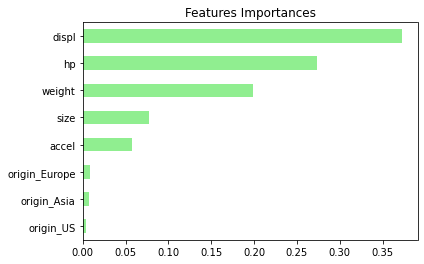

In [ ]:
# Create a pd.Series of features importances
importances = pd.Series(data=rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## Chapter 4.

* AdaBoost
* Gradient Boosting

Adaboost classifier.

In [ ]:
df = get_breast_cancer_data()

# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate dt
dt = DecisionTreeClassifier(max_depth=2, random_state=1)

# Instantiate ada with 180 trees 
ada = AdaBoostClassifier(base_estimator=dt, n_estimators=180, random_state=1)

# Fit ada to the training set
ada.fit(X_train, y_train)

# Compute the probabilities of obtaining the positive class
y_pred_proba = ada.predict_proba(X_test)[:,1]

print(y_pred_proba[:5])

[0.28972891 0.77791417 0.63830207 0.38370219 0.20174933]


In [ ]:
# Evaluate test-set roc_auc_score
ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print roc_auc_score
print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

ROC AUC score: 0.97


Gradient Boosting regressor.

In [ ]:
df = get_auto_data()

# Define feature and target
X = df.iloc[:,1:]
y = df.mpg

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)
            
# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

# Print R^2
print('Test set R^2 of gb: {:.3f}'.format(r2_score(y_test, y_pred)))

Test set RMSE of gb: 4.062
Test set R^2 of gb: 0.707


Stochastic Gradient Boosting.

In [ ]:
df = get_auto_data()

# Define feature and target
X = df.iloc[:,1:]
y = df.mpg

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a stochastic GradientBoostingRegressor 'sgbt'
sgbt = GradientBoostingRegressor(max_depth=1, subsample=0.8, max_features=0.2,
                                 n_estimators=300, random_state=1)

# Fit 'sgbt' to the training set
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

# Print R^2
print('Test set R^2 of gb: {:.3f}'.format(r2_score(y_test, y_pred)))

Test set RMSE of gb: 4.079
Test set R^2 of gb: 0.704


## Chapter 5.

* Grid search CV hyperparameter tuning

Grid search CV for regression task.

In [ ]:
df = get_breast_cancer_data()

# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Setup rf model
rf = RandomForestClassifier()

# Define the dictionary 'params_rf'
params_rf = {'n_estimators': [100, 350, 500], 
             'max_features': ['log2', 'auto', 'sqrt'], 
             'min_samples_leaf': [2, 10, 30]}

# Instantiate grid_rf
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=params_rf,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-1)

# Fit to train data
grid_rf.fit(X_train, y_train)

# Extract the best estimator and hyperparameters
best_model = grid_rf.best_estimator_
best_hyperparams = grid_rf.best_params_
print(best_model)
print(best_hyperparams)

# Predict test set labels
y_pred = best_model.predict(X_test)

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

# Print R^2
print('Test set R^2 of gb: {:.3f}'.format(r2_score(y_test, y_pred)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   28.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 500}
Test set RMSE of gb: 0.306
Test set R^2 of gb: 0.598


Grid search CV for classification task.

In [ ]:
df = get_breast_cancer_data()

# Define feature and target
X = df[['radius_mean', 'concave points_mean']].values
y = df.diagnosis.values

y = y.astype('int') # To convert float to int. Otherwise, it throws error "ValueError"

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate dt
dt = DecisionTreeClassifier()

# Define params_dt
params_dt = {'max_depth':[2,3,4], 'min_samples_leaf':[0.12, 0.14, 0.16, 0.18]}

# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)

# Fit to training data
grid_dt.fit(X_train, y_train)

# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

# Extract the best estimator and hyperparameters
best_model = grid_dt.best_estimator_
best_hyperparams = grid_dt.best_params_
print(best_model)
print(best_hyperparams)

# Predict the test set probabilities of the positive class
y_pred_proba = grid_dt.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

# Print test_roc_auc
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.16, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
{'max_depth': 4, 'min_samples_leaf': 0.16}
Test set ROC AUC score: 0.964
